In [46]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


In [47]:

# --- Data Loading ---
def load_yield_data(filepath, target_date, interpolate=True):
    """Load and process yield curve data for a specific date with optional interpolation."""
    try:
        df = pd.read_csv(filepath)
        data_on_date = df[df['Date'] == target_date].copy()
        if data_on_date.empty:
            raise ValueError(f"No data found for date {target_date}")
        
        target_date = pd.to_datetime(target_date)
        all_maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
        
        # Filter maturities after target date
        maturities = []
        for mat in all_maturities:
            try:
                mat_date = pd.to_datetime(mat, format='%b%Y')
                if mat_date > target_date:
                    maturities.append(mat)
            except ValueError:
                continue
        
        if not maturities:
            raise ValueError(f"No valid maturities found for date {target_date}")
        
        # Convert columns to numeric
        for mat in maturities:
            time_col = f'Time_{mat}'
            yield_col = f'Yield_{mat}'
            if time_col in data_on_date.columns:
                data_on_date[time_col] = pd.to_numeric(data_on_date[time_col], errors='coerce')
            if yield_col in data_on_date.columns:
                data_on_date[yield_col] = pd.to_numeric(data_on_date[yield_col], errors='coerce')
        
        valid_cols = [f'Time_{mat}' for mat in maturities if f'Time_{mat}' in data_on_date.columns] + \
                     [f'Yield_{mat}' for mat in maturities if f'Yield_{mat}' in data_on_date.columns]
        data_on_date = data_on_date.dropna(subset=valid_cols)
        
        if data_on_date.empty:
            raise ValueError(f"No valid data after dropping NaN for date {target_date}")
        
        # Extract times and yields
        times = np.array([data_on_date[f'Time_{mat}'].values[0] for mat in maturities])
        yields = np.array([data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]) * 100
        valid_idx = ~np.isnan(times) & ~np.isnan(yields)
        times, yields = times[valid_idx], yields[valid_idx]
        
        if interpolate:
            # Interpolate to a standard time grid (0.25 to 15 years)
            standard_times = np.linspace(0.25, 15.0, 60)
            if len(times) > 1:
                interp_yields = np.interp(standard_times, times, yields, left=np.nan, right=np.nan)
                valid_interp = ~np.isnan(interp_yields)
                times = standard_times[valid_interp]
                yields = interp_yields[valid_interp]
            else:
                raise ValueError(f"Insufficient valid data points for interpolation on {target_date}")
        
        return times, yields
    except Exception as e:
        raise Exception(f"Error loading data for {target_date}: {str(e)}")


In [48]:

# --- Two-Factor Vasicek Model ---
class Two_Factor_Model:
    def __init__(self, x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2):
        self.x1_0 = x1_0
        self.x2_0 = x2_0
        self.mu1 = mu1
        self.mu2 = mu2
        self.vol1 = vol1
        self.var1 = vol1 * vol1
        self.vol2 = vol2
        self.var2 = vol2 * vol2
        self.kappa1 = kappa1
        self.kappa2 = kappa2
    
    def B(self, tau, kappa):
        return (1 - np.exp(-kappa * tau)) / kappa

    def A(self, tau, mu, var, kappa):
        return (mu / kappa - var / (2 * kappa**2)) * (self.B(tau, kappa) - tau) - var * self.B(tau, kappa)**2 / (4 * kappa)

    def zero(self, t0, T, x1_t0, x2_t0):
        tau = T - t0
        A1 = self.A(tau, self.mu1, self.var1, self.kappa1)
        A2 = self.A(tau, self.mu2, self.var2, self.kappa2)
        B1 = self.B(tau, self.kappa1)
        B2 = self.B(tau, self.kappa2)
        price = np.exp(A1 + A2 - B1 * x1_t0 - B2 * x2_t0)
        return max(price, 1e-10)
    
    def yield_curve(self, tau):
        if tau <= 0:
            return np.nan
        p = self.zero(0, tau, self.x1_0, self.x2_0)
        return -np.log(p) / tau * 100
    
    def update_params(self, x):
        self.x1_0 = max(x[0], 0)
        self.x2_0 = max(x[1], 0)
        self.mu1 = x[2]
        self.mu2 = x[3]
        self.vol1 = max(x[4], 1e-6)
        self.var1 = pow(self.vol1, 2)
        self.vol2 = max(x[5], 1e-6)
        self.var2 = pow(self.vol2, 2)
        self.kappa1 = max(x[6], 1e-6)
        self.kappa2 = max(x[7], 1e-6)
    
    def simulate_paths(self, T, dt, n_paths):
        n_steps = int(T / dt)
        times = np.linspace(0, T, n_steps + 1)
        x1 = np.zeros((n_paths, n_steps + 1))
        x2 = np.zeros((n_paths, n_steps + 1))
        x1[:, 0] = self.x1_0
        x2[:, 0] = self.x2_0
        
        # Generate independent Brownian motions (rho = 0)
        for t in range(1, n_steps + 1):
            dW1 = np.random.normal(0, np.sqrt(dt), n_paths)
            dW2 = np.random.normal(0, np.sqrt(dt), n_paths)
            x1[:, t] = x1[:, t-1] + self.kappa1 * (self.mu1 - x1[:, t-1]) * dt + self.vol1 * dW1
            x2[:, t] = x2[:, t-1] + self.kappa2 * (self.mu2 - x2[:, t-1]) * dt + self.vol2 * dW2
        
        r_paths = x1 + x2
        return times, r_paths, x1, x2


In [49]:

# --- Fitter Class ---
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)  # Observed yields
        self.times = np.array(obs_times)  # Maturities
        self.dist = dist
        self.model_yields = None  # Store predicted yields after fitting
        self.n_params = 8  # Number of parameters in two-factor Vasicek (x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2)

    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def r_squared(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        y_mean = np.mean(self.data)
        ss_tot = np.sum((self.data - y_mean) ** 2)  # Total sum of squares
        ss_res = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        return 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    def rmse(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        return np.sqrt(np.mean((self.data - self.model_yields) ** 2))

    def aic(self):
        if self.model_yields is None:
            raise ValueError("Model must be fitted first.")
        n = len(self.data)  # Number of observations
        rss = np.sum((self.data - self.model_yields) ** 2)  # Residual sum of squares
        # AIC = n * ln(RSS/n) + 2 * k, where k is number of parameters
        return n * np.log(rss / n) + 2 * self.n_params if rss > 0 else np.nan

    def fit(self, x0, solver='trf'):
        bounds = ([0, 0, -np.inf, -np.inf, 0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        result = least_squares(self.residuals, x0, method=solver, bounds=bounds)
        self.model.update_params(result.x)
        self.model_yields = np.array([self.model.yield_curve(t) for t in self.times])  # Store predictions
        return result


In [50]:

# --- Forecasting ---
def forecast_yields(model, times, forecast_date, dt=1/252, n_paths=5000):
    """Forecast yields for a future date using Monte Carlo simulation."""
    forecast_days = (pd.to_datetime(forecast_date) - pd.to_datetime('2025-01-31')).days
    T = forecast_days / 365.0
    sim_times, r_paths, x1_paths, x2_paths = model.simulate_paths(T, dt, n_paths)
    x1_forecast = x1_paths[:, -1]
    x2_forecast = x2_paths[:, -1]
    
    # Compute yields for each simulated path
    forecast_yields = []
    for t in times:
        yields_t = []
        for x1, x2 in zip(x1_forecast, x2_forecast):
            model.x1_0, model.x2_0 = x1, x2  # Temporarily update state
            y = model.yield_curve(t)
            yields_t.append(y)
        forecast_yields.append(np.mean(yields_t))
    
    # Compute standard deviation for confidence intervals
    forecast_std = []
    for t in times:
        yields_t = []
        for x1, x2 in zip(x1_forecast, x2_forecast):
            model.x1_0, model.x2_0 = x1, x2
            y = model.yield_curve(t)
            yields_t.append(y)
        forecast_std.append(np.std(yields_t))
    
    # Restore original parameters
    model.x1_0 = x1_paths[0, 0]
    model.x2_0 = x2_paths[0, 0]
    
    return {
        'mean': np.array(forecast_yields),
        'lower': np.array(forecast_yields) - 1.96 * np.array(forecast_std),
        'upper': np.array(forecast_yields) + 1.96 * np.array(forecast_std),
        'confidence': 0.95,
        'times': times
    }


In [51]:

# --- Metrics Calculation ---
def calculate_metrics(observed, predicted):
    """Calculate RMSE and R-squared for observed vs predicted yields."""
    rmse = np.sqrt(np.mean((observed - predicted) ** 2))
    y_mean = np.mean(observed)
    ss_tot = np.sum((observed - y_mean) ** 2)
    ss_res = np.sum((observed - predicted) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return rmse, r2


In [52]:
# --- Plot Yields  ---
def plot_yields(dt, obs_times, obs_yields, model, min_time=0, max_time=15, num_points=100, rmse=None, r2=None):
    # Create a dense grid of maturities for both model and interpolated STRIPS
    time_grid = np.linspace(min_time, max_time, num_points)
    
    # Interpolate STRIPS yields
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    
    # Model yields
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    
    # Plot interpolated STRIPS data as a dotted line with markers
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    
    # Plot model curve as a solid line
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    
    # Add RMSE and R^2 to the legend if provided
    if rmse is not None and r2 is not None:
        plt.plot([], [], ' ', label=f'RMSE: {rmse:.2f}%')
        plt.plot([], [], ' ', label=f'R²: {r2:.2f}')
    
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

In [53]:
# --- Plot Forecast  ---
def plot_forecast_yields(dt, obs_times, obs_yields, forecast, model, min_time=0, max_time=15, num_points=100, rmse=None, r2=None):
    time_grid = np.linspace(min_time, max_time, num_points)
    
    # Interpolate observed yields
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    obs_yields_interp = interp_func(time_grid)
    
    # Interpolate forecast yields
    forecast_func = interp1d(forecast['times'], forecast['mean'], kind='linear', bounds_error=False, fill_value='extrapolate')
    forecast_yields_interp = forecast_func(time_grid)
    
    # Interpolate confidence bands
    lower_func = interp1d(forecast['times'], forecast['lower'], kind='linear', bounds_error=False, fill_value='extrapolate')
    upper_func = interp1d(forecast['times'], forecast['upper'], kind='linear', bounds_error=False, fill_value='extrapolate')
    lower_interp = lower_func(time_grid)
    upper_interp = upper_func(time_grid)
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    
    # Plot observed yields
    plt.plot(time_grid, obs_yields_interp, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    
    # Plot forecasted yields
    plt.plot(time_grid, forecast_yields_interp, label='Forecast', linestyle='solid', color='green')
    
    # Add RMSE and R^2 to the legend if provided
    if rmse is not None and r2 is not None:
        plt.plot([], [], ' ', label=f'RMSE: {rmse:.2f}%')
        plt.plot([], [], ' ', label=f'R²: {r2:.2f}')
    
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve Forecast for {dt}')
    plt.grid(True)
    plt.show()


In [54]:

# # --- Main Execution ---
# filepath = '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv'
# dates = ['2025-01-31', '2025-02-04', '2025-03-04', '2025-04-04']

# # Load data with consistent maturities
# # standard_times = np.linspace(0.25, 15.0, 60)  # Define standard time grid
# # data = {}
# # for date in dates:
# #     times, yields = load_yield_data(filepath, date, interpolate=True)
# #     # Interpolate yields to standard_times
# #     if len(times) > 1:
# #         interp_yields = np.interp(standard_times, times, yields, left=np.nan, right=np.nan)
# #         valid_idx = ~np.isnan(interp_yields)
# #         data[date] = (standard_times[valid_idx], interp_yields[valid_idx])
# #     else:
# #         raise ValueError(f"Insufficient data points for {date}")


# # times_jan31, yields_jan31 = load_yield_data(filepath, '2025-01-31')
# # times_feb04, yields_feb04 = load_yield_data(filepath, '2025-02-04')
# # times_mar04, yields_mar04 = load_yield_data(filepath, '2025-03-04')
# # times_apr04, yields_apr04 = load_yield_data(filepath, '2025-04-04')

# # # Verify that all times are identical
# # min_length = min(len(times_jan31), len(times_feb04), len(times_mar04), len(times_apr04))
# # times_jan31 = times_jan31[:min_length]
# # times_feb04 = times_feb04[:min_length]
# # times_mar04 = times_mar04[:min_length]
# # times_apr04 = times_apr04[:min_length]

# # assert np.all(times_jan31 == times_feb04) and np.all(times_feb04 == times_mar04) and np.all(times_mar04 == times_apr04), \
# #     "Maturities are not consistent across dates"

# # Initial parameters for two-factor model
# x0 = [0.02, 0.02, 0.01, 0.01, 0.05, 0.05, 0.3, 0.1]  # [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]
# bounds = (
#     [0, 0, -0.1, -0.1, 1e-6, 1e-6, 1e-6, 1e-6],
#     [0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 1.0, 0.5]
# )


In [55]:
# --- Main Execution ---
filepath = '/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv'
dates = ['2025-01-03', '2025-01-31', '2025-02-04', '2025-03-04', '2025-04-04']

# Load data for all dates
data = {}
for date in dates:
    times, yields = load_yield_data(filepath, date, interpolate=True)
    data[date] = (times, yields)

times_jan03, yields_jan03 = data['2025-01-03']
times_jan31, yields_jan31 = data['2025-01-31']
times_feb04, yields_feb04 = data['2025-02-04']
times_mar04, yields_mar04 = data['2025-03-04']
times_apr04, yields_apr04 = data['2025-04-04']

# Initial parameters for two-factor model
x0 = [0.02, 0.02, 0.01, 0.01, 0.05, 0.05, 0.3, 0.1]  # [x1_0, x2_0, mu1, mu2, vol1, vol2, kappa1, kappa2]


Jan 31 Fit Metrics:
$R^2$: 0.99
RMSE: 0.02%
AIC: -286.92
Jan 31 Optimized Params: [ 2.40002163e-02  7.03906644e-06 -2.73780147e-01  3.68042273e-01
  4.19463749e-01  1.94413657e-04  1.00728593e+00  9.05251864e-01]


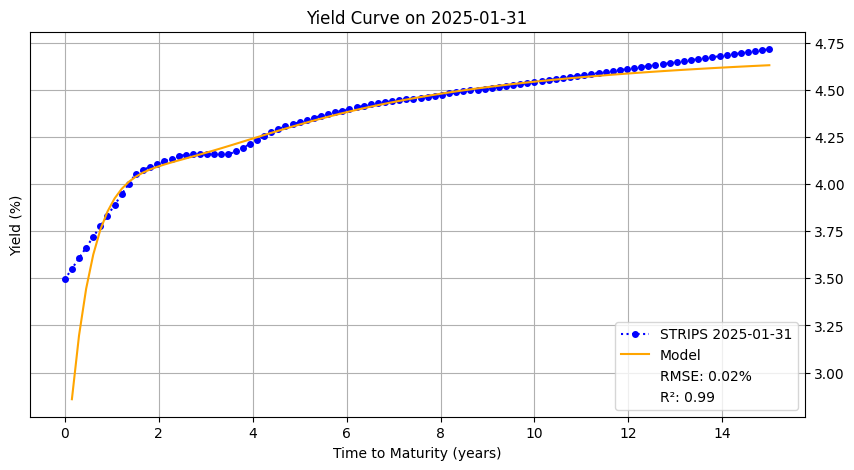

In [56]:

# Step 1: Fit model to Jan 31 data
model = Two_Factor_Model(*x0)
fitter = Fitter(model, yields_jan31, times_jan31)
fit_result = fitter.fit(x0, solver='trf')
print("Jan 31 Fit Metrics:")
print(f"$R^2$: {fitter.r_squared():.2f}")
print(f"RMSE: {fitter.rmse():.2f}%")
print(f"AIC: {fitter.aic():.2f}")
print("Jan 31 Optimized Params:", fit_result.x)
plot_yields('2025-01-31', times_jan31, yields_jan31, model, rmse=fitter.rmse(), r2=fitter.r_squared())



Feb 4 Initial Forecast Metrics:
$R^2$: 0.97
RMSE: 0.03%
Feb 4 Optimized Fit Metrics:
$R^2$: 0.99
RMSE: 0.02%
AIC: -284.76
Feb 4 Optimized Params: [ 2.31051337e-02  3.01631651e-08 -9.65732323e-01  1.06417114e+00
  4.39605417e-01  8.15735902e-03  1.00002550e+00  9.58855924e-01]


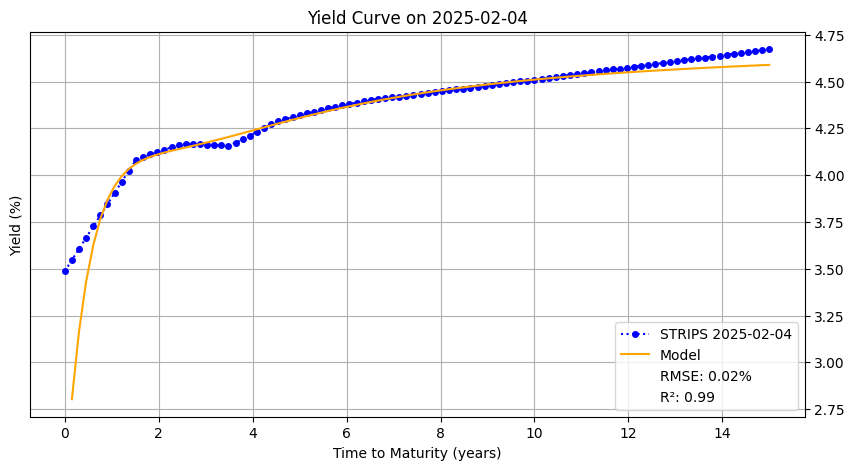

In [57]:

# Step 2: Forecast and optimize for Feb 04
feb04_forecast = forecast_yields(model, times_feb04, '2025-02-04', n_paths=5000)
print("\nFeb 4 Initial Forecast Metrics:")
rmse_feb04, r2_feb04 = calculate_metrics(yields_feb04, feb04_forecast['mean'])
print(f"$R^2$: {r2_feb04:.2f}")
print(f"RMSE: {rmse_feb04:.2f}%")

# Optimize model parameters to match Feb 04 observed data
fitter = Fitter(model, yields_feb04, times_feb04)
fit_result_feb04 = fitter.fit(fit_result.x, solver='trf')
print("Feb 4 Optimized Fit Metrics:")
content = f"$R^2$: {fitter.r_squared():.2f}\nRMSE: {fitter.rmse():.2f}%\nAIC: {fitter.aic():.2f}"
print(content)
print("Feb 4 Optimized Params:", fit_result_feb04.x)
plot_yields('2025-02-04', times_feb04, yields_feb04, model, rmse=fitter.rmse(), r2=fitter.r_squared())



Mar 4 Initial Forecast Metrics:
$R^2$: -11.20
RMSE: 0.40%
Mar 4 Optimized Fit Metrics:
$R^2$: 0.98
RMSE: 0.02%
AIC: -302.47
Mar 4 Optimized Params: [ 4.24533131e-02  1.85665679e-06 -1.07416058e+00  1.11056957e+00
  2.10889086e-01  8.17980513e-03  9.68668092e-01  9.43261264e-01]


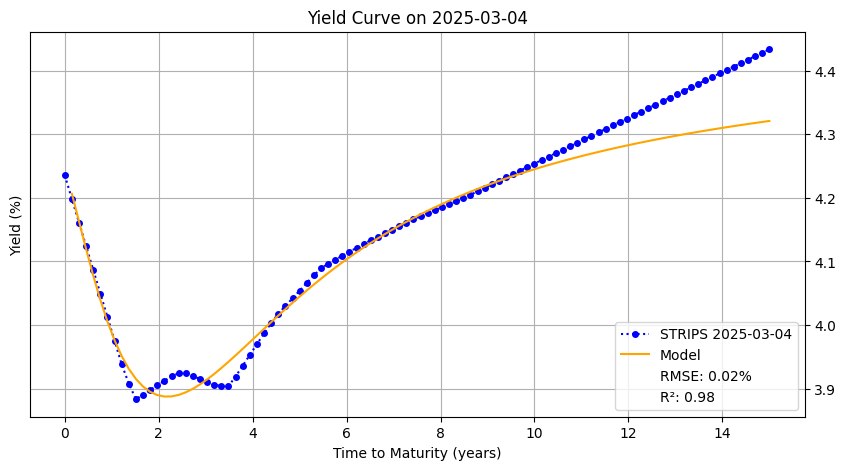

In [58]:

# Step 3: Forecast and optimize for Mar 04
mar04_forecast = forecast_yields(model, times_mar04, '2025-03-04', n_paths=5000)
print("\nMar 4 Initial Forecast Metrics:")
rmse_mar04, r2_mar04 = calculate_metrics(yields_mar04, mar04_forecast['mean'])
print(f"$R^2$: {r2_mar04:.2f}")
print(f"RMSE: {rmse_mar04:.2f}%")

# Optimize model parameters to match Mar 04 observed data
fitter = Fitter(model, yields_mar04, times_mar04)
fit_result_mar04 = fitter.fit(fit_result_feb04.x, solver='trf')
print("Mar 4 Optimized Fit Metrics:")
content = f"$R^2$: {fitter.r_squared():.2f}\nRMSE: {fitter.rmse():.2f}%\nAIC: {fitter.aic():.2f}"
print(content)
print("Mar 4 Optimized Params:", fit_result_mar04.x)
plot_yields('2025-03-04', times_mar04, yields_mar04, model, rmse=fitter.rmse(), r2=fitter.r_squared()) 



Apr 4 Forecast Metrics:
$R^2$: -1.95
RMSE: 0.27%


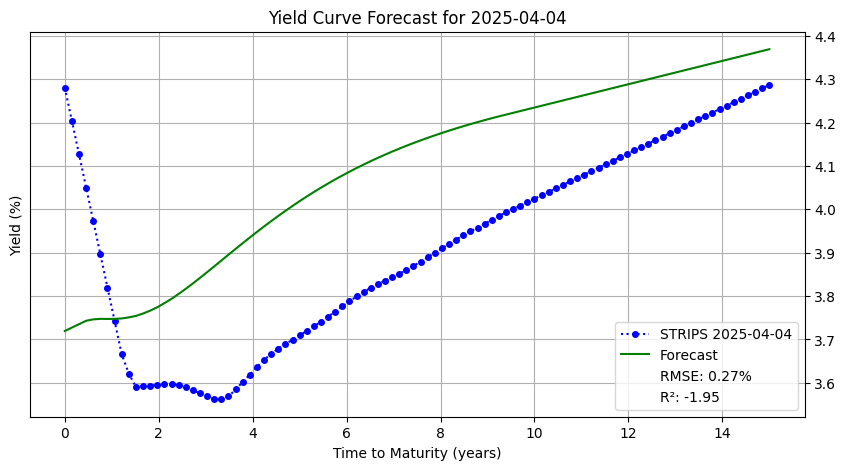

In [59]:

# Step 4: Forecast for Apr 04 and compare with test data
apr04_forecast = forecast_yields(model, times_apr04, '2025-04-04', n_paths=5000)
rmse_apr04, r2_apr04 = calculate_metrics(yields_apr04, apr04_forecast['mean'])
print("\nApr 4 Forecast Metrics:")
content = f"$R^2$: {r2_apr04:.2f}\nRMSE: {rmse_apr04:.2f}%"
print(content)
plot_forecast_yields('2025-04-04', times_apr04, yields_apr04, apr04_forecast, model, rmse=rmse_apr04, r2=r2_apr04)


In [60]:

# Print final diagnostics
print("\nFinal Diagnostics:")
print("Feb 4 Forecasted Yields:", feb04_forecast['mean'])
print("Mar 4 Forecasted Yields:", mar04_forecast['mean'])
print("Apr 4 Forecasted Yields:", apr04_forecast['mean'])


Final Diagnostics:
Feb 4 Forecasted Yields: [3.78098986 3.92585362 4.01099019 4.06186471 4.09389152 4.11620696
 4.13406315 4.15034068 4.16649902 4.18316884 4.2005171  4.2184685
 4.23683688 4.25540054 4.27394314 4.29227395 4.31023587 4.32770656
 4.34459612 4.36084292 4.37640903 4.39127575 4.40543942 4.41890796
 4.43169778 4.44383142 4.45533551 4.46623926 4.47657327 4.48636859
 4.49565606 4.50446584 4.51282703 4.52076749 4.52831364 4.53549046
 4.54232142]
Mar 4 Forecasted Yields: [3.38455421 3.82352295 4.07802928 4.22105893 4.29813835 4.33737881
 4.35589658 4.3639102  4.36734836 4.36950387 4.37207697 4.37582876
 4.38098628 4.3874902  4.39514326 4.40369663 4.41289803 4.42251642
 4.43235297 4.44224394 4.45205941 4.46169973 4.47109128 4.48018202
 4.48893745 4.49733696 4.50537069 4.51303703 4.52034044 4.52728979
 4.53389705 4.54017618 4.54614238 4.55181146 4.55719941 4.56232204
 4.56719475 4.57183241]
Apr 4 Forecasted Yields: [3.73251731 3.74551373 3.74758009 3.74720552 3.74866124 3.7537596

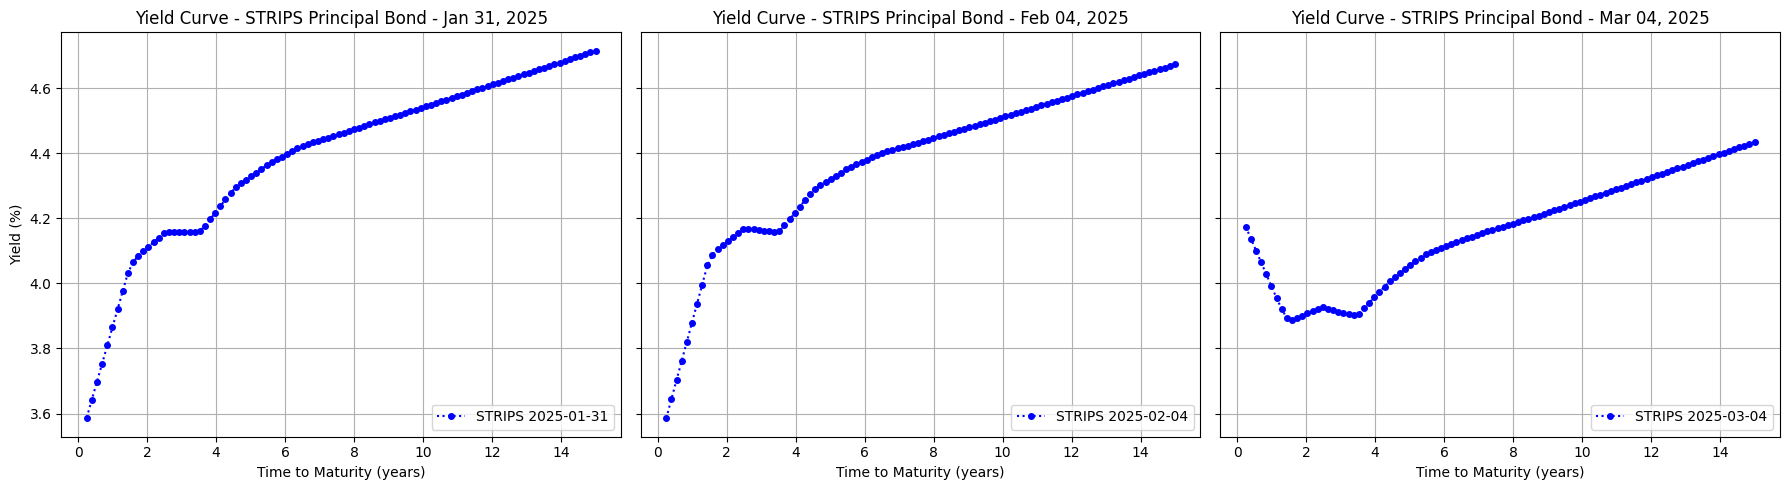

In [ ]:
# Plotting all yield curves
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Jan 31
time_grid_jan = np.linspace(0.25, 15, 100)
interp_jan = interp1d(times_jan31, yields_jan31, kind='linear', bounds_error=False, fill_value='extrapolate')
axs[0].plot(time_grid_jan, interp_jan(time_grid_jan), linestyle='dotted', marker='o', color='blue', markersize=4, label='STRIPS 2025-01-31')
axs[0].set_title('Yield Curve - STRIPS Principal Bond - Jan 31, 2025')
axs[0].set_xlabel('Time to Maturity (years)')
axs[0].set_ylabel('Yield (%)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Feb 04
time_grid_feb = np.linspace(0.25, 15, 100)
interp_feb = interp1d(times_feb04, yields_feb04, kind='linear', bounds_error=False, fill_value='extrapolate')
axs[1].plot(time_grid_feb, interp_feb(time_grid_feb), linestyle='dotted', marker='o', color='blue', markersize=4, label='STRIPS 2025-02-04')
axs[1].set_title('Yield Curve - STRIPS Principal Bond - Feb 04, 2025')
axs[1].set_xlabel('Time to Maturity (years)')
axs[1].legend(loc='lower right')
axs[1].grid(True)

# Mar 04
time_grid_mar = np.linspace(0.25, 15, 100)
interp_mar = interp1d(times_mar04, yields_mar04, kind='linear', bounds_error=False, fill_value='extrapolate')
axs[2].plot(time_grid_mar, interp_mar(time_grid_mar), linestyle='dotted', marker='o', color='blue', markersize=4, label='STRIPS 2025-03-04')
axs[2].set_title('Yield Curve - STRIPS Principal Bond - Mar 04, 2025')
axs[2].set_xlabel('Time to Maturity (years)')
axs[2].legend(loc='lower right')
axs[2].grid(True)

plt.tight_layout()
plt.show()